In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from tqdm import tqdm
import numpy as np
import copy

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score

/home/samoed/.pyenv/versions/3.10.4/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
topics = pd.read_csv("topic_words.csv.zip")
topics.head()

,meta,topic,weight,type,word
0,env,Экология в целом,5,0,экологичный
1,env,Экология в целом,5,0,природоохранный
2,env,Экология в целом,1,0,экология
3,env,Экология в целом,5,0,воздействие
4,env,Экология в целом,5,0,окружающая среда


In [3]:
re_dict = {}
re_advanced_dict = {}
sheets_dict = {}
sheets_advanced_dict = {}
base_dict = {}
advanced_dict = {}
importance_dict = {}

for idx, row in topics.iterrows():
    if not sheets_dict.get(row["topic"], False):
        sheets_dict[row["topic"]] = {}
        sheets_advanced_dict[row["topic"]] = {}
        base_dict[row["topic"]] = {}
        advanced_dict[row["topic"]] = {}
    if row["word"].find(",") != -1:
        continue
    sheets_dict[row["topic"]][row["word"]] = row["weight"]  # row["type"]
    if row["type"] == 1:
        sheets_advanced_dict[row["topic"]][row["word"]] = row["weight"]
        advanced_dict[row["topic"]][row["word"]] = 0
    base_dict[row["topic"]][row["word"]] = 0
    importance_dict[row["topic"]] = 0

In [4]:
for key, val in sheets_dict.items():
    re_dict[key] = re.compile("((?<!\w)" + "(?!\w)|(?<!\w)".join(val.keys()) + "(?!\w))")

In [5]:
for key, val in sheets_advanced_dict.items():
    re_advanced_dict[key] = re.compile("((?<!\w)" + "(?!\w)|(?<!\w)".join(val.keys()) + "(?!\w))")

In [6]:
df = pd.read_excel("topics/paragraph_max_values_50.xlsx", sheet_name="paragraph_max_values_50", index_col=0).rename(
    columns={"Экспертный топик Вера": "true_expert"}
)
df.head()

,company,year,sector,report_type,paragraph,original_text,cleaned_text,max_topic_cos,max_score_cos,second_max_topic_cos,second_max_score_cos,true_expert,Экспертный топик МА,Комментарий
2023915.0,ПАО «Газпром»,"2015, 2014",Энергетика,ОУР,1942.0,Компании Группы Газпром вносят свой вклад в ре...,компания группа газпром вносить свой вклад реа...,Биоразнообразие,0.678372,NaN,NaN,Биоразнообразие,NaN,NaN
1515679.0,ПАО «Газпром»,2011,Энергетика,ЭО,761.0,"пересажено более 3 000 редких растений, в том ...",пересадить редкий растение число реликтовый ви...,Биоразнообразие,0.657152,NaN,NaN,Биоразнообразие,NaN,NaN
699878.0,Госкорпорация «Росатом»,2018,Энергетика,ИО,1288.0,Вклад в сохранение биоразнообразия мощности до...,активность радионуклид поступить сточный вода ...,Биоразнообразие,0.647845,NaN,NaN,Биоразнообразие,NaN,NaN
699878.0,Госкорпорация «Росатом»,2018,Энергетика,ИО,1288.0,"_x000c_Активность бета-активных радионуклидов,...",активность радионуклид поступить сточный вода ...,Биоразнообразие,0.647845,NaN,NaN,NaN,NaN,"сложный кейс, безопасность населения"
1383089.0,ПАО «Газпром»,2014,Энергетика,ЭО,1165.0,"«Белоплечий орлан», «Птицы Сахалина», «Реки Са...",белоплечий орлан птица сахалин река сахалин ки...,Биоразнообразие,0.647845,NaN,NaN,Биоразнообразие,NaN,NaN


In [7]:
df = df[df["true_expert"].notna()]

In [8]:
def get_scores(text: str, label: str, imp: int = 0) -> dict[str, float | None]:
    paragraph_dict = copy.deepcopy(base_dict)
    paragraph_importance = copy.deepcopy(importance_dict)
    found_words = False
    base_words = {}
    advanced_words = {}
    paragraph_len = len(text.split())
    adv_vocab = {}
    for key, regex in re_dict.items():
        words = regex.findall(text)
        # advanced_words_found = re_advanced_dict[key].findall(text)
        for word in words:
            found_words = True
            weight = sheets_dict[key][word]
            paragraph_dict[key][word] = weight
            paragraph_importance[key] += weight > 1
        base_words[key] = len(words)
        # advanced_words[key] = len(advanced_words_found)

    if not found_words:
        res = {key: 0 for key in sheets_dict}
        return {**res, **{"max_score_cos": None, "max_topic_cos": None, "count_words": None}}

    result_topic = []
    results = []
    for percent in np.arange(0, 1, 0.01):
        res = {}
        count_dict = {}
        for key, vector in sheets_dict.items():
            count_dict[f"{key}_words_percent"] = base_words[key] / paragraph_len
            if base_words[key] / paragraph_len < percent or paragraph_importance[key] < imp:
                res[key] = 0
                continue
            sim = cosine_similarity(X=[list(vector.values())], Y=[list(paragraph_dict[key].values())])[0][0]
            res[key] = sim

        res_sorted = sorted(res.items(), key=lambda x: x[1], reverse=True)
        max_value = res_sorted[0]
        result_topic.append(max_value[0] == label)
        max_value = list(max_value)
        if max_value[1] == 0:
            max_value[0] = "безтопика"
        results.append(res | count_dict | {"topic": max_value[0], "topic_score": max_value[1]})

    return result_topic, results

In [10]:
pred_labels = []
acc = 0
results = []
percentile = 10
for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    text = row["cleaned_text"]
    label = row["true_expert"]
    pred, res = get_scores(text, label, 1)
    pred_labels.append(pred)
    # if res[percentile]["topic"] == "безтопика": # for 15
    if pred[percentile] is False: # for 10
        results.append(
            {
                "company": row["company"],
                "year": row["year"],
                "text": row["original_text"],
                "cleaned_text": text,
                "expert_topic": label,
            }
            | res[percentile]
        )

100%|██████████| 1610/1610 [07:07<00:00,  3.77it/s]


In [11]:
len(results)

0

In [12]:
par = pd.DataFrame(results)
par.head()

""


In [13]:
# par.to_csv("without_topic_0,15.csv")
par.to_csv("not_recognized_0,8.csv")

In [14]:
df = pd.DataFrame(pred_labels)

In [15]:
acc = [df[col].sum() / df.shape[0] for col in df.columns]

[]

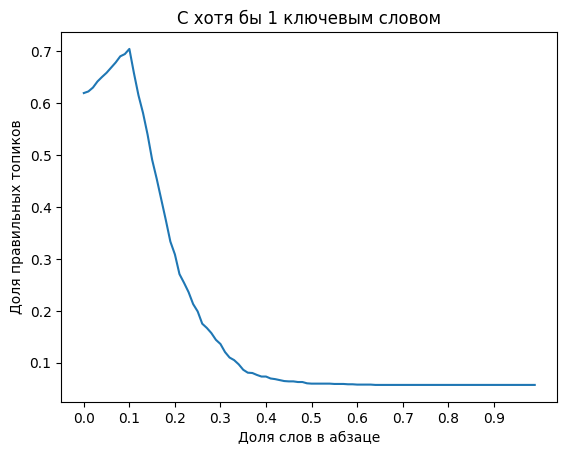

In [16]:
plt.plot(acc)
values = []
for i, val in enumerate(np.arange(0, 1, 0.01)):
    if i % 10 == 0:
        values.append(round(val, 2))
    else:
        values.append(None)
plt.title("С хотя бы 1 ключевым словом")
plt.xticks(range(len(acc))[::10], values[::10])
plt.xlabel("Доля слов в абзаце")
plt.ylabel("Доля правильных топиков")
plt.savefig("at_least_1_keyword.png", dpi=300)
plt.plot()

In [17]:
acc

[0.6198757763975156,
 0.6229813664596273,
 0.6304347826086957,
 0.6422360248447205,
 0.6509316770186335,
 0.6590062111801243,
 0.668944099378882,
 0.6788819875776397,
 0.6906832298136646,
 0.6950310559006211,
 0.7049689440993789,
 0.6583850931677019,
 0.615527950310559,
 0.5813664596273292,
 0.5397515527950311,
 0.49130434782608695,
 0.4546583850931677,
 0.41490683229813663,
 0.37515527950310557,
 0.33354037267080744,
 0.30869565217391304,
 0.2708074534161491,
 0.25403726708074537,
 0.2360248447204969,
 0.21304347826086956,
 0.19875776397515527,
 0.17515527950310558,
 0.1670807453416149,
 0.15714285714285714,
 0.14409937888198757,
 0.1360248447204969,
 0.12049689440993788,
 0.10993788819875776,
 0.10496894409937889,
 0.0968944099378882,
 0.08633540372670807,
 0.08074534161490683,
 0.08012422360248447,
 0.07639751552795031,
 0.07329192546583851,
 0.07329192546583851,
 0.06956521739130435,
 0.06832298136645963,
 0.06645962732919254,
 0.06459627329192547,
 0.06397515527950311,
 0.06397515